In [21]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")


In [22]:
# 天気情報の値についてtrainとtestで異なるので、別々でダミー変数化するとカラムの数が合わない
# trainとtestを識別するための適当な変数
train["t"] = 1
test["t"] = 0
# datにてtrainとtestを一度結合する。
# dat上でダミー変数化を一気に行う
dat = pd.concat([train,test],sort=True).reset_index(drop=True)

In [23]:
dat.index = pd.to_datetime(dat["datetime"])
dat = dat["2014-05-01":]
dat = dat.reset_index(drop=True)

In [24]:
# 天気情報のダミー変数化
# datにてダミー変数化を行う
dat["days"] = dat.index
dat["precipitation"] = dat["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float64)
dat["fun"] = dat["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
dat["curry"] = dat["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
dat["subuta"] = dat["name"].apply(lambda x : 1 if x.find("酢豚")>=0 else 0)
dat["sp"] = dat["remarks"].apply(lambda x : 1 if x==("スペシャルメニュー")>=0 else 0)
dat["kd"] = dat["remarks"].apply(lambda x : 1 if x==("料理長")>=0 else 0)

cols = ["precipitation","weather","days","fun","curry","y","subuta","sp","kd"]

In [25]:
# pythonの機械学習ライブラリ（scikit-learn）
# 現代の主力はTensorFlowやPyTorch
# 今回はbase環境にpipコマンドでisntallしている
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [26]:
# 線形回帰とランダムフォレストのスタッキング
# 線形回帰で全体の傾向を捉え、ランダムフォレストで残差を補完
# trainX:学習データ、y_train:目的変数(売り上げ数)
def learning(trainX,y_train):
    model1 = LR() #線形回帰
    model2 = RF(n_estimators=100,max_depth=4,random_state=777) #ランダムフォレスト
    model1.fit(trainX["days"].values.reshape(-1,1),y_train) #日付のみで学習
    pred = model1.predict(trainX["days"].values.reshape(-1,1)) #pred = predict:予測値

    pred_sub = y_train - pred
    model2.fit(trainX.iloc[:, ~trainX.columns.str.match("y")],pred_sub)
    return model1, model2

In [27]:
# クロスバリデーションの設定
kf = KFold(n_splits=5,random_state=777,shuffle=True)
# trainデータを抽出
tr = dat[dat["t"]==1][cols] # この時すでに変数"t"は"tt"に変化している

# クロスバリデーション
# trainデータを5分割して、4分割で学習、1分割で評価を繰り返す
# 5分割にしたので、これを5回繰り返す
# 最終的に5回の評価結果の平均をとる
# これにより、過学習を防ぎ、モデルの汎化性能を評価できる
# ただし、計算コストが高くなる
# 今回はデータ数が少ないので、クロスバリデーションを採用
# なお、testデータは最終的な評価用にとっておく
# testデータは学習に一切使わない

In [28]:
# 学習と評価のRMSEを格納するリスト
trains = []
tests = []

# クロスバリデーションの実行
for train_index, test_index in kf.split(tr): # 実際にデータを挿入
    tr.loc[train_index,"tt"] = 1
    tr.loc[test_index,"tt"] = 0 # 学習用データと評価用データを識別を入れる
    tr["tt"] = tr["tt"].astype(int)
    tmp = pd.get_dummies(tr)
    
    trainX = tmp[tmp["tt"]==1]
    del trainX["tt"] 
    testX = tmp[tmp["tt"]==0]
    del testX["tt"]
    y_train = tmp[tmp["tt"]==1]["y"]
    y_test = tmp[tmp["tt"]==0]["y"]

    model1, model2 = learning(trainX,y_train)

    pred_train = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:, ~trainX.columns.str.match("y")])
    pred_test = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:, ~testX.columns.str.match("y")])
    
    print("TRAIN:",MSE(y_train,pred_train)**0.5, "VARIDATE",MSE(y_test, pred_test)**0.5)
    trains.append(MSE(y_train,pred_train)**0.5)
    tests.append(MSE(y_test, pred_test)**0.5)


# 学習と評価のRMSEを表示
# 最終的に学習と評価のRMSEの平均を表示
# 学習と評価のRMSEが近いほど、過学習していない
# 学習のRMSEが低いほど、モデルの性能が高い
# 評価のRMSEが低いほど、モデルの汎化性能が高い
# ただし、評価のRMSEが低いほど、過学習している可能性もある
print("AVG")
print(np.array(trains).mean(), np.array(tests).mean())



TRAIN: 7.814878284369383 VARIDATE 10.905959729647835
TRAIN: 7.941149753112676 VARIDATE 10.216141505199165
TRAIN: 8.214215181683148 VARIDATE 7.695163156950248
TRAIN: 7.23491831660683 VARIDATE 13.642638980482682
TRAIN: 8.179394074561436 VARIDATE 9.795446398205067
AVG
7.876911122066694 10.451069954097


In [29]:
# 最終的な学習と予測のための前処理
cols = ["precipitation","weather","days","curry","y","t","fun"] 
tmp = pd.get_dummies(dat[cols])
trainX = tmp[tmp["t"]==1]
del trainX["t"]
testX = tmp[tmp["t"]==0]
del testX["t"]
y_train = tmp[tmp["t"]==1]["y"]
y_test = tmp[tmp["t"]==0]["y"]

RMSE 7.984076391060993


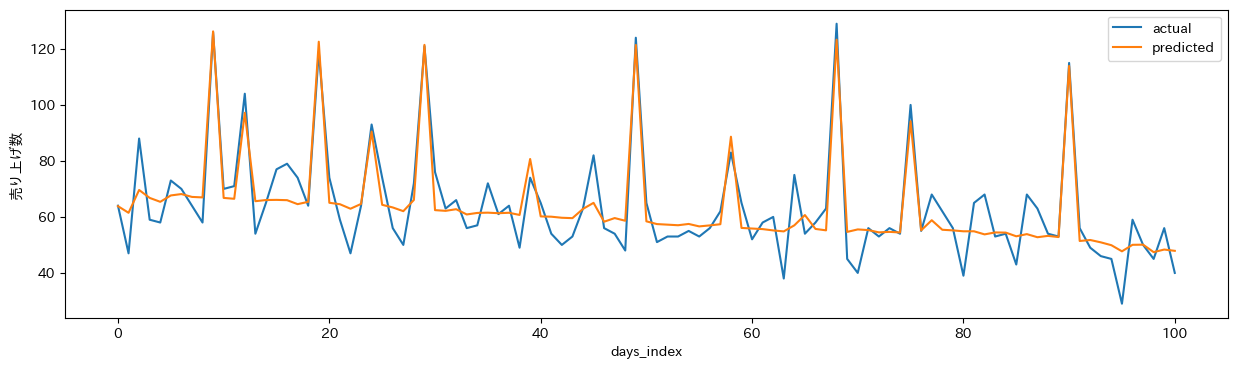

In [33]:
# 最終的な学習と予測
model1, model2 = learning(trainX,y_train)
pred = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:,~trainX.columns.str.match("y")])
# 評価
p = pd.DataFrame({"actual":y_train,"predicted":pred})
ax = p.plot(figsize=(15,4))
ax.set_xlabel("days_index")
ax.set_ylabel("売り上げ数")
print("RMSE",MSE(y_train,pred)**0.5)



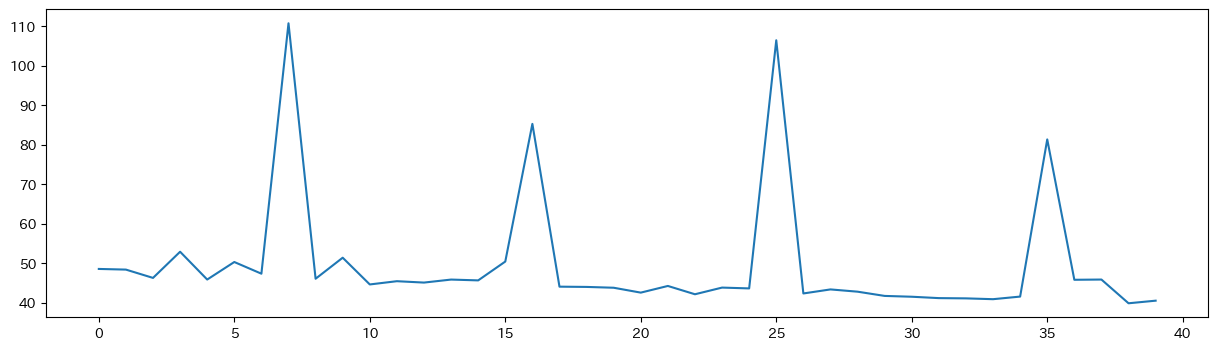

In [ ]:
# 予測結果のプロット
model1, model2 = learning(trainX,y_train)
pred = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:,~testX.columns.str.match("y")])
plt.figure(figsize=(15,4))
plt.plot(pred)

In [ ]:
new_row = pd.DataFrame([{"2014-10-1":"2014-10-1","24":24}])
sample = pd.concat([new_row,sample],ignore_index=True)

In [ ]:
sample[1] = pred
sample = sample.drop("24",axis=1)
sample
#sample.to_csv("submit05.csv",index=False,header=False)

,2014-10-1,1
0,2014-10-1,48.507383
1,2014-10-2,48.340275
2,2014-10-3,46.234835
3,2014-10-6,52.865906
4,2014-10-7,45.820344
5,2014-10-8,50.263948
6,2014-10-9,47.304049
7,2014-10-10,110.766785
8,2014-10-14,46.022597
9,2014-10-15,51.355070


In [ ]:
#sample[1] = pd.Series(pred)
#sample.to_csv("submit01.csv",index=None,header=None)

# pd.Seriesを用いずに実行したとき一行目でエラーが発生した。
# numpyの場合はバリューとインデックスの数が正確に一致していないといけないためだ。
# そこでpredをpd.Seriesに変換することで不一致部分をnullにして回避している。
# sabmitは正常に行われなかった

In [ ]:
#sample[1] = pd.Series(pred)
#sample = sample.drop("24",axis=1)
#sample.to_csv("submit02.csv",index=None,header=None)
# submit02では"24"のカラムをdropした
# submitは正常に行われなかった

In [ ]:
#sample[1] = pred
# sample.csvを直接いじった
#sample = sample.drop("None.1",axis=1)
#sample.to_csv("submit04.csv",index=None,header=None)
# submitは正常に行われた

In [ ]:
# その後新たに説明変数"subuta","sp","kd"を追加してみたがモデルの精度は下がってしまった。
# RMSEの値が増えてしまった。多重共線性が生まれてしまった？過学習が起きてしまった？
# colsの中身の順序を変えたらRMSEの値が減った。説明変数を入れる順序が性能に関係するのか？
# 弱い予想だが説明変数の追加は十分で、モデルのチューニングが必要なのかもしれない。
# SIGNATEのpublic評価が(誤差だが)下がってしまった。